#Neural Style Transfer

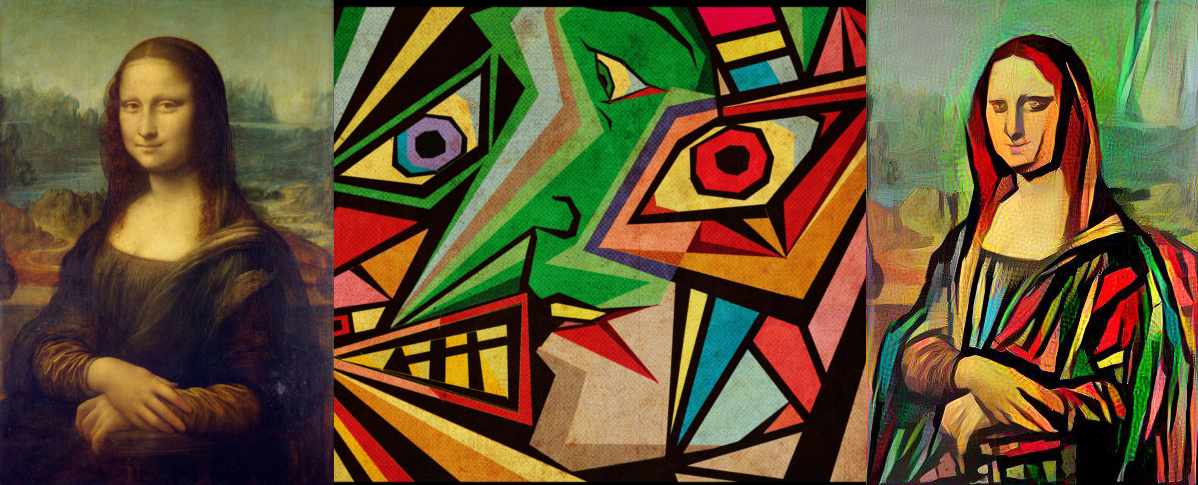

**Neural style transfer** is a technique in deep learning that allows the artistic style of one image (the "style image") to be transferred to the content of another image (the "content image"), resulting in a new image that combines the content of the content image with the style of the style image. This process is based on optimizing the input image to minimize both its content distance from the content image and its style distance from the style image.

The process typically involves the following steps:

1. **Initialization:** Start with a randomly generated image or a copy of the content image.

2. **Feature Extraction:** Use a pre-trained convolutional neural network (CNN), such as VGG or ResNet, to extract features from the content image, the style image, and the generated image. Different layers of the CNN capture different levels of abstraction.

3. **Content Loss:** Define a loss function that measures the difference in content between the features of the generated image and the content image. This loss encourages the generated image to preserve the structure and content of the content image.

4. **Style Loss:** Define a loss function that measures the difference in style between the features of the generated image and the style image. This loss encourages the generated image to match the textures, colors, and patterns of the style image.

5. **Total Loss:** Combine the content loss and style loss into a total loss function. The total loss is a weighted sum of the content loss and style loss, where the weights control the relative importance of content and style in the final image.

6. **Optimization:** Use an optimization algorithm, such as gradient descent or L-BFGS, to minimize the total loss with respect to the pixel values of the generated image. During optimization, the generated image gradually evolves to better match both the content and style of the input images.

7. **Output:** The optimized image, also known as the stylized image, is the final result of the neural style transfer process. It combines the content of the content image with the style of the style image, creating a visually appealing artistic composition.

Neural style transfer has applications in various fields, including digital art, photo editing, and visual effects, and it allows for the creation of unique and stylized images inspired by famous artworks or personal preferences.

In [19]:
# Importing the Basic Library:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
from torch import nn
import numpy as np
print(torch.__version__)
print(torchvision.__version__)

2.2.0
0.17.0


In [2]:
# Model Agnostic Code:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Function for Loading and resize the image:
def image_loader(image_path,size=(934,1160)):
    h,w = size
    image = Image.open(image_path).resize((w,h))
    image = transforms.ToTensor()(image).unsqueeze(dim=0)
    return image

In [4]:
# Function to Show the image:
def image_show(tensor,title):
    image = tensor.squeeze(dim=0).permute(1,2,0)
    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis(False)

(-0.5, 1159.5, 933.5, -0.5)

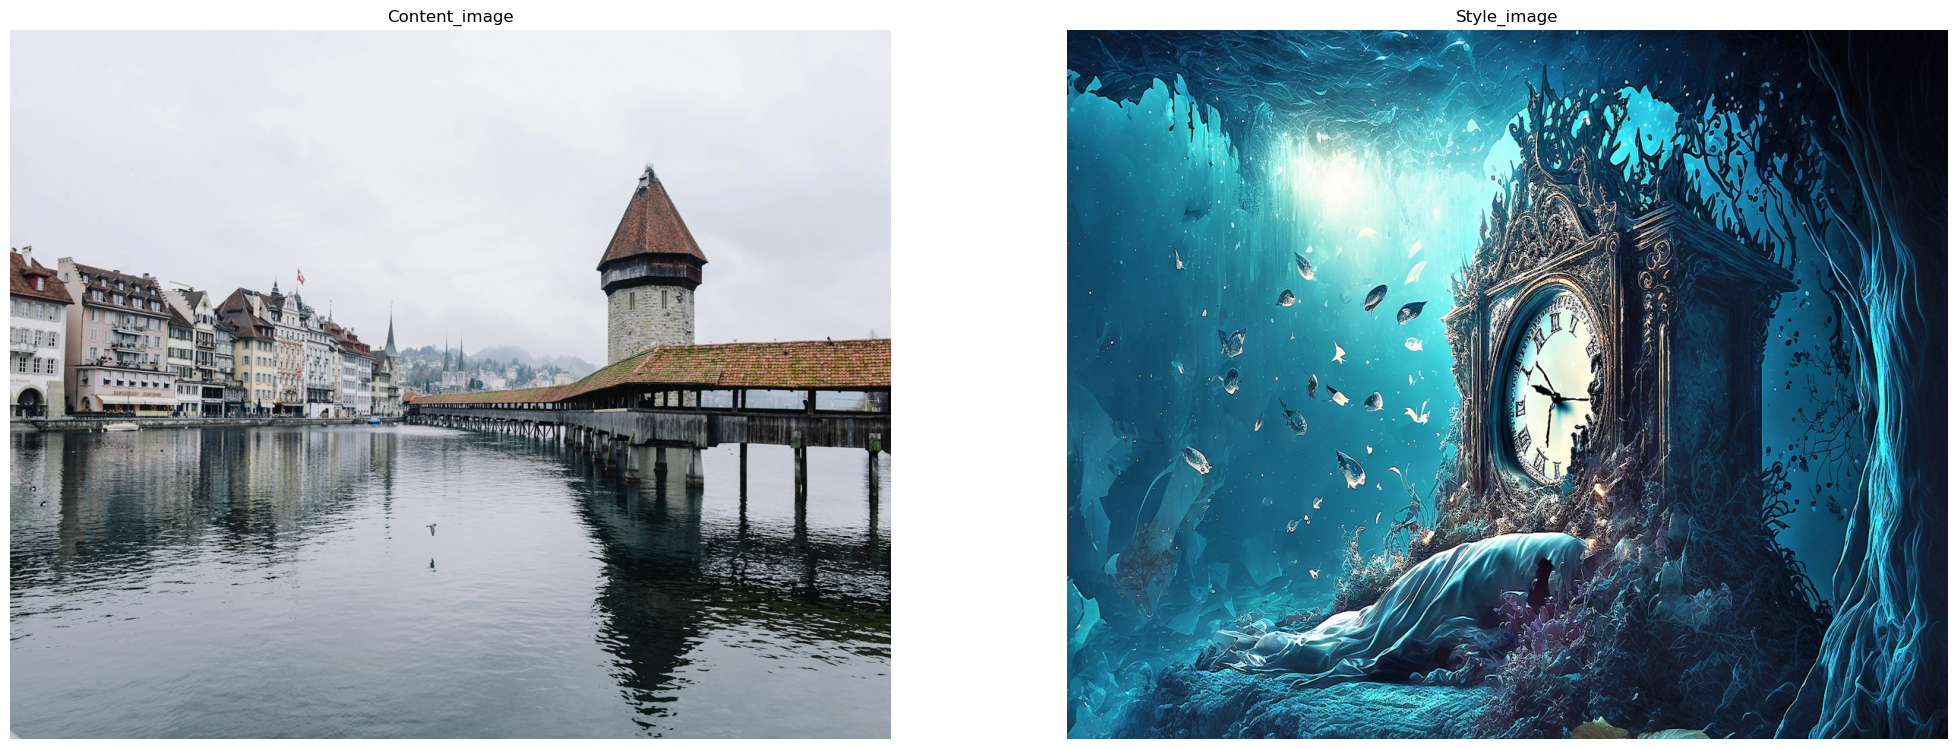

In [5]:
# Plot the content and Style images:

img_path_content = Path(r"E:\Pytoch projects\content_image.jpg")
content_image = image_loader(img_path_content)
content_image = content_image.squeeze(dim=0).permute(1,2,0)

img_path_style = Path(r"E:\Pytoch projects\style_image.jpg")
style_image = image_loader(img_path_style)
style_image = style_image.squeeze(dim=0).permute(1,2,0)

plt.figure(figsize=(25, 20))
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.title('Content_image')
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(style_image)
plt.title('Style_image')
plt.axis(False)

**Normalization class, for Normalizing Both the 3 layers by mean and standard deviation given in Pytorch Documentation**

https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19



In [6]:

class NormalizationLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, image):
        dev = image.device
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(dev)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(dev)
        return (image - mean)/std


**Content Loss Function:**

1. The content loss function measures the difference in content between two images.
2. It is typically calculated using a feature map from a layer in a pre-trained convolutional neural network (CNN).
3. The content loss compares the feature representations of the content image and the generated image at a particular layer in the network.
4. Common choices for the content loss function include mean squared error (MSE) or mean absolute error (MAE) between the feature maps.

In [7]:
 # Create the Loss for the Content image and Generated Image, it is simply Mean Square Error:

class content_loss_layer(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self,pred):
        self.loss = torch.mean((pred-self.target)**2)
        # Returning the prediction becaues it is going to usefull in making the Model.
        return pred

**Style Loss Function:**

1. The style loss function measures the difference in style between two images.
2. It captures the statistical properties of textures, patterns, and colors in an image.
3. Style loss is computed by comparing the Gram matrices of feature maps from different layers in a CNN.
4. The Gram matrix is formed by taking the inner product of the vectorized feature maps, capturing the correlations between different features.
5. The style loss function is typically computed as the MSE or MAE between the Gram matrices of the style image and the generated image.

In [8]:
# Creating function for Gram Matrix it is simply converting the image to 2D and multily by its Transpose:

def gram_matrix(image):
    N, C, H, W = image.size()
    features = image.reshape(N * C, H * W)
    gram = torch.mm(features,features.t())
    return torch.div(gram,N * C * H * W)

In [9]:
# Create the Loss for style:

class style_loss_layer(nn.Module):
    def __init__(self, target) :
        super().__init__()
        self.target = target.detach()

    def forward(self,pred):
        pred_gram = gram_matrix(pred)
        target_gram = gram_matrix(self.target)
        self.loss = torch.mean((pred_gram - target_gram)**2)
        return pred


In [10]:
# Create the Compiler class:

class Compiler():
    def __init__(self, baseModel, contentLayerNames, styleLayerNames, device='cuda'):
        self.baseModel = baseModel.to(device)
        self.contentLayerNames = contentLayerNames
        self.styleLayerNames = styleLayerNames


    def compile(self, contentImage, styleImage, device='cuda'):
        contentImage = contentImage.to(device)
        styleImage = styleImage.to(device)
        contentLayers=[]
        styleLayers=[]
        model = nn.Sequential()
        model.add_module('norm', NormalizationLayer())
        i = 0
        # Initialize the Loop for creating model and append the Required Conv layer to the Sequential Layer:
        for layer in self.baseModel.children():
            # Check if layer is Conv;
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv{}'.format(i)
            # Check if layer is RELU and keep it in seprate layer, inplace =  False
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}'.format(i)
                layer = nn.ReLU(inplace=False)
            # Check if layer is Maxpool:
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool{}'.format(i)
            # Check if Layer is Batch Norm:
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            # Append the Layer and name to model:
            model.add_module(name, layer)

            # Creating the content Loss Layer:
            if name in self.contentLayerNames:
                target = model(contentImage).detach()
                layer = content_loss_layer(target)
                model.add_module("content{}".format(i), layer)
                contentLayers.append(layer)

            # Create the style Loss Layer:
            if name in self.styleLayerNames:
                target = model(styleImage).detach()
                layer = style_loss_layer(target)
                model.add_module("style{}".format(i), layer)
                styleLayers.append(layer)
        # Make sure last layer is either of content or style Loss:
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], content_loss_layer) or isinstance(model[i], style_loss_layer):
                break
        model = model[:(i + 1)]
        return model, contentLayers, styleLayers

In [11]:
# Creating the Training class:

class Trainer():
    def __init__(self, model, contentLayers, styleLayers, device='cuda:0'):
        self.model = model.to(device)
        self.contentLayers = contentLayers
        self.styleLayers = styleLayers

    def fit(self, image, epochs=10, alpha=1, betta=1e6, device='cuda:0'):
        image = image.to(device)
        optimizer = torch.optim.LBFGS([image.requires_grad_(True)])
        content_losses=[]
        style_losses=[]
        total_losses=[]
        for epoch in range(1, epochs+1):
            def closure():
                image.clamp(0, 1)
                optimizer.zero_grad()
                self.model(image)

                content_loss=0.
                style_loss=0.

                for contentLayer in self.contentLayers:
                    content_loss += contentLayer.loss
                for styleLayer in self.styleLayers:
                    style_loss += styleLayer.loss

                loss = alpha*content_loss + betta*style_loss
                loss.backward()
                content_losses.append(alpha*content_loss.item())
                style_losses.append(betta*style_loss.item())
                total_losses.append(loss.item())
                return loss
            optimizer.step(closure)

            print('Epoch {}/{} --- Total Loss: {:.4f} '.format(epoch, epochs, total_losses[-1]))
            print('Content Loss: {:4f} --- Style Loss : {:4f}'.format(content_losses[-1], style_losses[-1]))
            print('---'*17)
        losses={'total': total_losses, 'content': content_losses, 'style': style_losses}
        return losses, torch.clamp(image, 0, 1)

In [12]:
# Download the VGG19 Model from the Pytorch and load its pretrained weights:
vgg19 = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT).features.eval()

# Creating the List of layers for both content and style:
contentLayerNames = ['conv4']
styleLayerNames = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

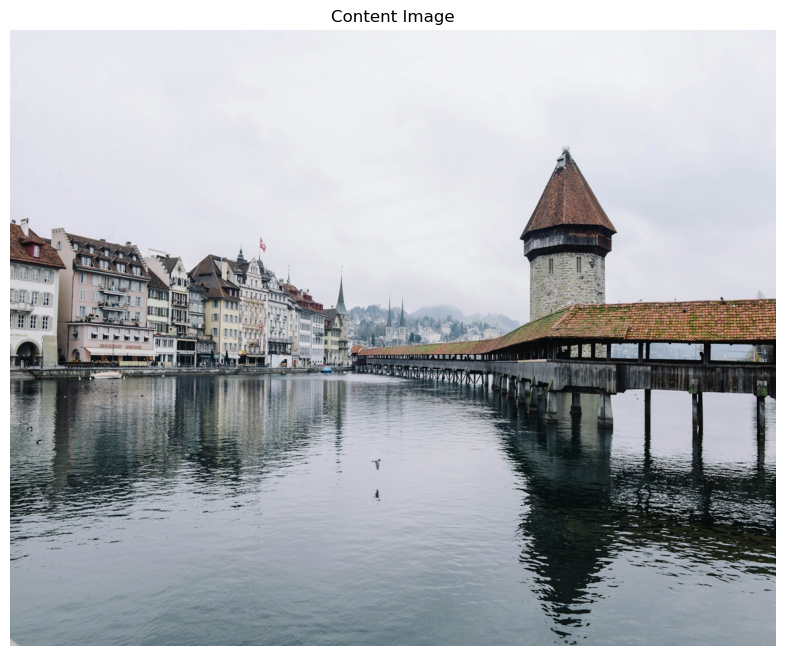

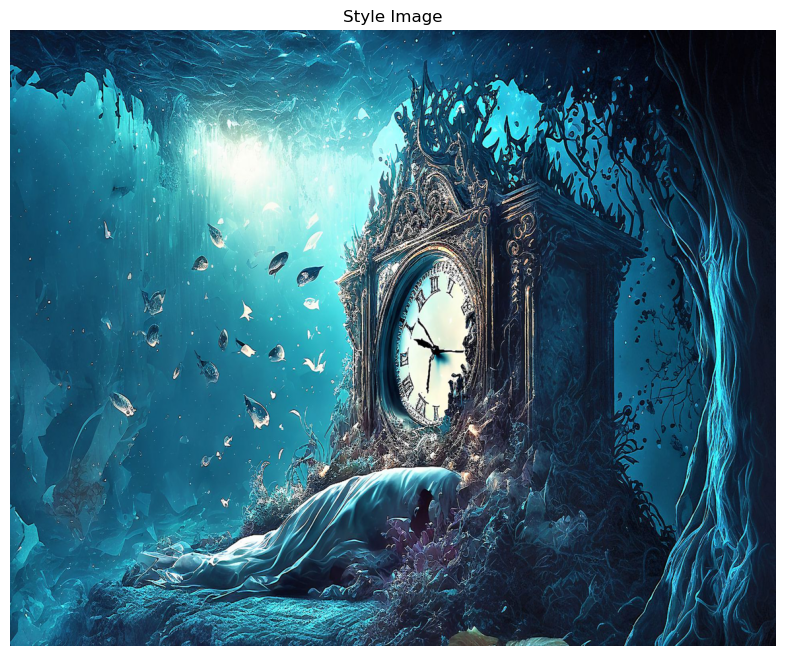

In [13]:
contentImage = image_loader(Path(r"E:\Pytoch projects\content_image.jpg"))
styleImage = image_loader(Path(r"E:\Pytoch projects\style_image.jpg"))

image_show(contentImage, title='Content Image')
image_show(styleImage, title='Style Image')

In [14]:
# Compile the Model:
compiler = Compiler(baseModel=vgg19,
                    contentLayerNames=contentLayerNames,
                    styleLayerNames=styleLayerNames)
model, contentLayers, styleLayers = compiler.compile(contentImage=contentImage,
                                                     styleImage=styleImage,
                                                     device='cuda')

In [15]:
# Train the Model:
trainer = Trainer(model, contentLayers, styleLayers, device)

inputImage = contentImage.clone()
losses, outImage = trainer.fit(inputImage)

Epoch 1/10 --- Total Loss: 2877.3020 
Content Loss: 21.266813 --- Style Loss : 2856.035251
---------------------------------------------------
Epoch 2/10 --- Total Loss: 374.4853 
Content Loss: 23.293898 --- Style Loss : 351.191382
---------------------------------------------------
Epoch 3/10 --- Total Loss: 219.7618 
Content Loss: 23.267401 --- Style Loss : 196.494439
---------------------------------------------------
Epoch 4/10 --- Total Loss: 173.8859 
Content Loss: 23.244720 --- Style Loss : 150.641223
---------------------------------------------------
Epoch 5/10 --- Total Loss: 132.6301 
Content Loss: 23.235783 --- Style Loss : 109.394263
---------------------------------------------------
Epoch 6/10 --- Total Loss: 109.9942 
Content Loss: 22.944136 --- Style Loss : 87.050030
---------------------------------------------------
Epoch 7/10 --- Total Loss: 91.7154 
Content Loss: 22.625984 --- Style Loss : 69.089438
---------------------------------------------------
Epoch 8/10 ---

## Result:

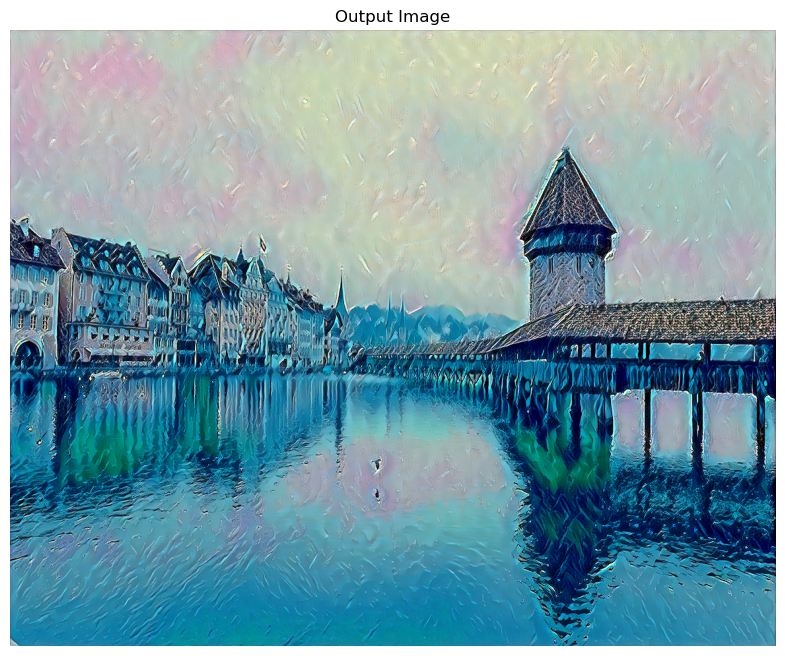

In [16]:
# Result:
result = outImage.detach().to('cpu')
image_show(result, title='Output Image')

Text(0.5, 1.0, 'Style_loss')

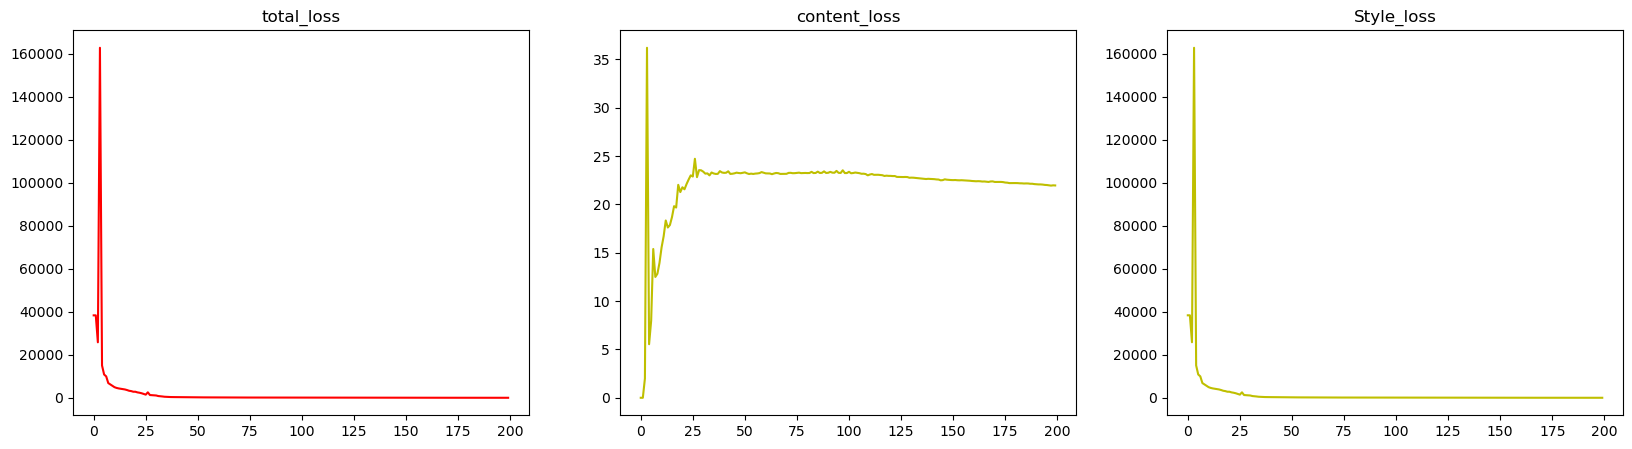

In [18]:
# Plotting the loss curves:

losses_total = losses['total']
losses_content = losses['content']
losses_style = losses['style']
x = range(len(losses_total))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(x,losses_total,c='r')
plt.title('total_loss')

plt.subplot(1,3,2)
plt.plot(x,losses_content,c='y')
plt.title('content_loss')

plt.subplot(1,3,3)
plt.plot(x,losses_style,c='y')
plt.title('Style_loss')

In [21]:
# Remove the batch dimension
result = result.squeeze(0)

# Convert the tensor to a numpy array
img_np = result.cpu().numpy()

# Convert the array from CHW to HWC format
img_np = np.transpose(img_np, (1, 2, 0))

# If the tensor values are in the range [0, 1], scale them to [0, 255]
img_np = (img_np * 255).astype(np.uint8)

# Save the image using matplotlib
plt.imsave('output_image.png', img_np)